### Aim:

In this notebook, KNN algorithm will be used to evaluate what additive effect (if any) ToxCast targets provide *for predicting mostDILI drugs* - when compared to existing predictors currently used in the field (eg: Chen M et al., 2016 Hepatol, Shah F et al., 2015 Toxicol Sci).

As before, same test/train data is used for this modeling to allow for comparison of model performance against alternative algorithms employed in separate notebooks.

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('seaborn') 

%matplotlib inline

import pandas_profiling

In [69]:
#magic command to print all output instead of only last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Read-in datasets, prepare data for ML

All datasets have been previously treated for missing values and dummy coding of categorical variables(reactive_metabolites, classificn, and ~216 toxcast targets).
Output/target/Y variable for modeling purposes is "classificn" (1="mostDILI", 0 = "other" which includes lessDILI/ambiDILI/noDILI). <br>

In this notebook, same datasets previosuly used for logistic regression modeling will be imported. No EDA will be performed as the datasetts are identical to those previously used and EDA has already been done within the notebook using logistic regression as initial model.

Data once imported will be transformed into feature dataset ("X") and label dataset ("Y") and further split using stratified sampling with call to test train split function. For allowing to compare results from logistic regression, same random state will be used as before.

In [70]:
mc = pd.read_csv("mc_scaled_labeled.csv")
tc = pd.read_csv("tc_pca_labeled.csv")
mc_tc=pd.read_csv("mctc_pca_labeled.csv")

In [71]:
#Create "x" consisting of all independent variables from each of the dataframes (mc, tc, mc_tc) to be used for modeling

mc_num=mc.select_dtypes(include=[np.number])
x_mc=mc_num.drop(["classificn"], axis=1)

tc_num=tc.select_dtypes(include=[np.number])
x_tc=tc_num.drop(["classificn"], axis=1)

mc_tc_num=mc_tc.select_dtypes(include=[np.number])
x_mc_tc=mc_tc_num.drop(["classificn"], axis=1)

In [72]:
#create "y" consisting of outcome/target variable from each of the dataframes (mc, tc, mc_tc) to be used for modeling

y_mc=mc_num["classificn"] 
y_tc=tc_num["classificn"]
y_mc_tc=mc_tc_num["classificn"]

#check to make sure all datasets are equivalent for classification column
y_mc.equals(y_tc)
y_mc.equals(y_mc_tc)
y_tc.equals(y_mc_tc)

#breakdown of mostDILI drugs vs other drugs
y_mc.value_counts()#60 drugs are labeled as "mostDILI" and 115 drugs as "other"

True

True

True

0    115
1     60
Name: classificn, dtype: int64

In [73]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics

## test train stratified split at 40:60 ratio (maintains ratio of mostDILI drugs:other drugs)
# allows for testing on 24 "mostDILI" and training on 36 "mostDILI" drugs
train_mcx, test_mcx, train_mcy, test_mcy = train_test_split(x_mc,y_mc, stratify=y_mc, test_size=0.4, random_state=45)

train_tcx, test_tcx, train_tcy, test_tcy = train_test_split(x_tc,y_tc, stratify=y_tc, test_size=0.4, random_state=45)

train_mctcx, test_mctcx, train_mctcy, test_mctcy = train_test_split(x_mc_tc,y_mc_tc, stratify=y_mc_tc, test_size=0.4, random_state=45)

#confirm that test datasets are same across all splits
test_mctcy.equals(test_tcy)
test_mcy.equals(test_tcy)

#train data distribution of 1's vs 0's
train_mcy.value_counts()

True

True

0    69
1    36
Name: classificn, dtype: int64

In [74]:
train_mcx.head()
x_mc.head()

,cmax,mol_wt,dailydose,logP,reactive_metabolites
66,-0.224248,1.708272,-0.541564,-0.728675,1.017292
55,-0.403543,-1.344926,-0.076238,-1.437584,1.017292
67,-0.403591,-0.340526,-0.628813,0.662220,1.017292
77,-0.403564,0.676282,-0.657431,-2.119571,-0.983002
121,-0.340790,-0.748993,-0.425233,-1.208759,1.017292


,cmax,mol_wt,dailydose,logP,reactive_metabolites
0,-0.246513,-0.411151,0.040093,-0.459470,1.017292
1,0.997393,-1.359063,2.832049,-0.791490,1.017292
2,-0.390792,-0.129961,-0.617180,1.873645,-0.983002
3,-0.394776,-0.558426,-0.192570,0.213544,1.017292
4,5.952769,-0.829645,0.796248,0.294306,1.017292


### KNN - initial model

In [75]:
# Instantiate and Fit
from sklearn.neighbors import KNeighborsClassifier

knn_mc = KNeighborsClassifier(n_neighbors=11) #start with n_neighbors(k) ~sqrt(number of rows in train data)
knn_tc = KNeighborsClassifier(n_neighbors=11)
knn_mctc = KNeighborsClassifier(n_neighbors=11)


knn_mc = knn_mc.fit(train_mcx, train_mcy)
knn_tc = knn_tc.fit(train_tcx, train_tcy)
knn_mctc = knn_mctc.fit(train_mctcx, train_mctcy)

#### Tune knn model for each of the datasets

In [76]:
# define the parameter values that should be searched
k_range = list(range(5, 50))
# Another parameter besides k that we might vary is the weights parameters
# default options --> uniform (all points in the neighborhood are weighted equally)
# another option --> distance (weights closer neighbors more heavily than further neighbors)
# we create a list
weight_options = ['uniform', 'distance']

In [77]:
# create a parameter grid: map the parameter names to the values that should be searched
# dictionary = dict(key=values, key=values)
param_grid = dict(n_neighbors=k_range, weights=weight_options)
#print(param_grid)


In [78]:
from sklearn.grid_search import GridSearchCV

grid_mc = GridSearchCV(estimator = knn_mc, cv=3, 
                    param_grid = dict(n_neighbors=k_range, weights=weight_options))

grid_tc = GridSearchCV(estimator = knn_tc, cv=3, 
                    param_grid = dict(n_neighbors=k_range, weights=weight_options))

grid_mctc= GridSearchCV(estimator = knn_mctc, cv=3, 
                    param_grid = dict(n_neighbors=k_range, weights=weight_options))


In [87]:
#"fit" grid search models (commented out to avoid re-execution)
grid_mc.fit(train_mcx,train_mcy)
grid_tc.fit(train_tcx, train_tcy)
grid_mctc.fit(train_mctcx, train_mctcy)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [89]:
print("knn best params follow below - mc data ")
grid_mc.best_params_
print("")

print("knn best params follow below - tc data ")
grid_tc.best_params_
print("")

print("knn best params follow below - mctc data ")
grid_mctc.best_params_
print("")

knn best params follow below - mc data 


{'n_neighbors': 36, 'weights': 'uniform'}


knn best params follow below - tc data 


{'n_neighbors': 5, 'weights': 'uniform'}


knn best params follow below - mctc data 


{'n_neighbors': 13, 'weights': 'uniform'}

#### Optimized knn model for each dataset

In [90]:
#Instantiate knn models with optimal parameters
knn_mc = KNeighborsClassifier(n_neighbors=36, weights='uniform')
knn_tc = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn_mctc = KNeighborsClassifier(n_neighbors=13, weights='uniform')

In [91]:
#Fit data to optimal model parameters
knn_mc.fit(train_mcx, train_mcy)
knn_tc.fit(train_tcx, train_tcy)
knn_mctc.fit(train_mctcx, train_mctcy)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=36, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform')

In [92]:
#Predict classification labels based on optimal model parameters

### Using knn model fitted using variables from Chen et al (mc), predict test values and probabilities  mc
knn_pred_mcy=knn_mc.predict(test_mcx) 
knn_probs_mcy=knn_mc.predict_proba(test_mcx) 

### Using knn model fitted using variables from ToxCast (tc), predict test values and probabilities  mc
knn_pred_tcy=knn_tc.predict(test_tcx) 
knn_probs_tcy=knn_tc.predict_proba(test_tcx) 

### Using knn model fitted using variables from Chen et al & ToxCast (mctc), predict test values and probabilities  mc
knn_pred_mctcy=knn_mctc.predict(test_mctcx) 
knn_probs_mctcy=knn_mctc.predict_proba(test_mctcx)    

#### Optimal knn models' metrics (for each dataset)

In [93]:
from sklearn.model_selection import cross_val_score

knn_accuracy_scores_mc = cross_val_score(knn_mc, x_mc, y_mc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on knn model using mc (Chen M et al., 2016 Hepatol) variables")
print(knn_accuracy_scores_mc)
print("Accuracy mean: " +str(knn_accuracy_scores_mc.mean()), "Accuracy standard deviation: " + str(knn_accuracy_scores_mc.std()))
print("")

knn_accuracy_scores_tc = cross_val_score(knn_tc, x_tc, y_tc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on knn model using tc (ToxCast targets/pathways) variables")
print(knn_accuracy_scores_tc)
print("Accuracy mean: " +str(knn_accuracy_scores_tc.mean()), "Accuracy standard deviation: " + str(knn_accuracy_scores_tc.std()))
print("")

knn_accuracy_scores_mctc = cross_val_score(knn_mctc, x_mc_tc, y_mc_tc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on knn model using combined mc and tc (Chen M et al, 2016 Hepatol and ToxCast) variables")
print(knn_accuracy_scores_mctc)
print("Accuracy mean: " +str(knn_accuracy_scores_mctc.mean()), "Accuracy standard deviation: " + str(knn_accuracy_scores_mctc.std()))

Accuracy: 3-fold cross validation scores on knn model using mc (Chen M et al., 2016 Hepatol) variables
[0.6779661  0.65517241 0.65517241]
Accuracy mean: 0.662770309760374 Accuracy standard deviation: 0.010745047522413927

Accuracy: 3-fold cross validation scores on knn model using tc (ToxCast targets/pathways) variables
[0.62711864 0.68965517 0.60344828]
Accuracy mean: 0.6400740307812196 Accuracy standard deviation: 0.036366548612157955

Accuracy: 3-fold cross validation scores on knn model using combined mc and tc (Chen M et al, 2016 Hepatol and ToxCast) variables
[0.66101695 0.65517241 0.67241379]
Accuracy mean: 0.6628677186830313 Accuracy standard deviation: 0.00715939015196298


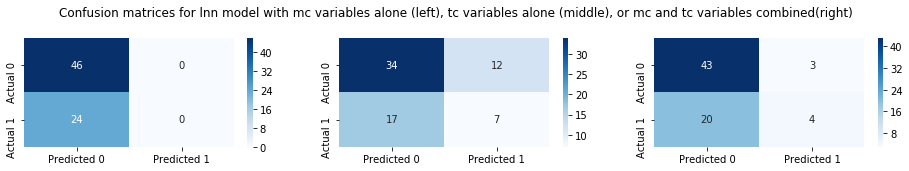

In [94]:
### Confusion Matrix
knn_cfm_mc=metrics.confusion_matrix(test_mcy, knn_pred_mcy)
knn_cfm_tc=metrics.confusion_matrix(test_tcy, knn_pred_tcy)
knn_cfm_mctc=metrics.confusion_matrix(test_mctcy, knn_pred_mctcy)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,2))

lbl1=["Predicted 0", "Predicted 1"]
lbl2=["Actual 0", "Actual 1"]

sns.heatmap(knn_cfm_mc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax1)
sns.heatmap(knn_cfm_tc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax2)
sns.heatmap(knn_cfm_mctc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax3)


fig.suptitle("Confusion matrices for lnn model with mc variables alone (left), tc variables alone (middle), or mc and tc variables combined(right)", y=1.1);

In [95]:
### Precision, Recall
knn_cr_mc=metrics.classification_report(test_mcy, knn_pred_mcy)
knn_cr_tc=metrics.classification_report(test_tcy, knn_pred_tcy)
knn_cr_mctc=metrics.classification_report(test_mctcy, knn_pred_mctcy)
print("precision_recall for model with mc variables alone")
print(knn_cr_mc)
print("precision_recall for model with tc variables alone")
print(knn_cr_tc)
print("precision_recall for model with mc&tc variables combined")
print(knn_cr_mctc)

precision_recall for model with mc variables alone
             precision    recall  f1-score   support

          0       0.66      1.00      0.79        46
          1       0.00      0.00      0.00        24

avg / total       0.43      0.66      0.52        70

precision_recall for model with tc variables alone
             precision    recall  f1-score   support

          0       0.67      0.74      0.70        46
          1       0.37      0.29      0.33        24

avg / total       0.56      0.59      0.57        70

precision_recall for model with mc&tc variables combined
             precision    recall  f1-score   support

          0       0.68      0.93      0.79        46
          1       0.57      0.17      0.26        24

avg / total       0.64      0.67      0.61        70



C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Conclusion:** KNN performs poorly relative to logistic regression for prediction of "mostDILI" label specifically, even though it performs excellent for prediction of "other" (i.e., non-mostDILI) drug classificaiton. <br>

Addition of toxcast variables as a modest benefit to model performance; however lgistic regression and SVM outperform knn in this scenario as well. KNN will not be considered further for mostDILI modeling with current datasets.